# HW7
# Name: Hyunwoo Roh

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from scipy.interpolate import LSQUnivariateSpline

# Question1: Multinomial logistic regression and cross validation

### (a) Use a multinomial logistic regression model of the following form with the following linear predictor
 
<br>(1) Estimate the model on a 75% sample training set using the following command. 
<br>(2) Report your two sets of estimated coecients and intercepts forj = 1 and j = 2 (not the coecients for j = 3). Report your error rates (1 - precision) on the test set using the code below. 
<br>(3) Which category(ies) of cultivar is the model best at predicting? 
<br>(4) Is (are) the most accurately predicted category(ies) the one(s) with the most observations? 
<br>(5) Report the MSE from the test set.

In [2]:
# read in data
df=pd.read_csv("data/strongdrink.txt")
df.describe()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,1.926136,13.006534,2.327159,2.367386,19.492045,99.840909,2.298920,2.043352,0.359545,1.597727,5.031761,0.961000,2.623409,748.477273
std,0.771047,0.814431,1.117747,0.275617,3.355821,14.329499,0.627333,0.995579,0.123046,0.571958,2.317965,0.227225,0.705369,316.208737
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.597500,2.210000,17.175000,88.000000,1.747500,1.242500,0.267500,1.250000,3.200000,0.790000,1.990000,500.000000
50%,2.000000,13.050000,1.845000,2.360000,19.500000,98.000000,2.380000,2.155000,0.340000,1.560000,4.640000,0.975000,2.780000,673.500000
75%,3.000000,13.682500,3.047500,2.560000,21.500000,107.250000,2.800000,2.882500,0.430000,1.952500,6.147500,1.120000,3.172500,986.250000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [3]:
df.cultivar.value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

In [4]:
# Training and testing sets
y=df["cultivar"]
X=df[["alco","malic","tot_phen","color_int"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=20)
y_test.count(), y_train.count()

(44, 132)

# Estimate and Report the results & error rates

In [5]:
Mlogit = LogisticRegression(solver='newton-cg',multi_class='multinomial')
result = Mlogit.fit(X_train, y_train)
pd.DataFrame({"j = 1":np.append(result.intercept_[0],result.coef_[0]),
              "j = 2":np.append(result.intercept_[1],result.coef_[1])},
               index=["beta0","beta1",'beta2','beta3','beta4'])

,j = 1,j = 2
beta0,-24.010989,22.802446
beta1,1.700403,-1.468044
beta2,-0.265605,-0.333053
beta3,1.223894,0.664012
beta4,0.022756,-0.922712


In [6]:
y_pred=result.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[13  0  0]
 [ 2 19  0]
 [ 0  0 10]]


In [7]:
print(classification_report(y_test, y_pred, digits=3))
print('The error rate (class 1) is', 1 - 0.867,
      '\nThe error rate (class 2) is', 1 - 1,
      '\nThe error rate (class 3) is', 1 - 1)

              precision    recall  f1-score   support

           1      0.867     1.000     0.929        13
           2      1.000     0.905     0.950        21
           3      1.000     1.000     1.000        10

   micro avg      0.955     0.955     0.955        44
   macro avg      0.956     0.968     0.960        44
weighted avg      0.961     0.955     0.955        44

The error rate (class 1) is 0.133 
The error rate (class 2) is 0 
The error rate (class 3) is 0


The model is best at predicting third group with the highest f1 score
And the most accurately predicted category is not the one with the most observations. However, the results here are not robust. When we try different random states, we can find that the results are not always robust. In this case, it is not sutible to make a conclusion since the test set is small.

In [8]:
print('The test MSE is', (y_test != y_pred).astype(int).mean())

The test MSE is 0.045454545454545456


# (b) Perform a leave-one-out cross validation (LOOCV)

1. Report your error rates (1 - precision) for each category? 
2. How do your error rates compare to those from part (a)? 
3. Report your LOOCV estimate for the test MSE as the average MSE, where yi is the left outobservation from each test set.

In [9]:
Xvals = df[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = df['cultivar'].values
N = Xvals.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvals)
MSE = pd.DataFrame({'index': np.zeros(N), 
                    'error': np.zeros(N), 
                    'y_pred': np.zeros(N),
                    'y_test': np.zeros(N)})

for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    Logit = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    Logit.fit(X_train, y_train)
    y_pred = Logit.predict(X_test)
    MSE['index'][test_index] = test_index
    MSE['error'][test_index] = (y_test != y_pred).astype(int)
    MSE['y_pred'][test_index] = y_pred
    MSE['y_test'][test_index] = y_test

error_1 = MSE[MSE['y_pred'] == 1]['error'].mean()
error_2 = MSE[MSE['y_pred'] == 2]['error'].mean()
error_3 = MSE[MSE['y_pred'] == 3]['error'].mean()
error_MSE = MSE['error'].mean()

In [10]:
print(classification_report(MSE['y_test'], MSE['y_pred'], digits=3))
print('')
print('The error rate for class 1 is', error_1, ', std is', MSE[MSE['y_pred'] == 1]['error'].values.std())
print('The error rate for class 2 is', error_2, ', std is', MSE[MSE['y_pred'] == 2]['error'].values.std())
print('The error rate for class 3 is', error_3, ', std is', MSE[MSE['y_pred'] == 3]['error'].values.std())
print('The average MSE (for all classes) is', error_MSE,', std is', MSE['error'].values.std())

              precision    recall  f1-score   support

         1.0      0.902     0.932     0.917        59
         2.0      0.914     0.901     0.908        71
         3.0      0.956     0.935     0.945        46

   micro avg      0.920     0.920     0.920       176
   macro avg      0.924     0.923     0.923       176
weighted avg      0.921     0.920     0.921       176


The error rate for class 1 is 0.09836065573770492 , std is 0.29780167417352377
The error rate for class 2 is 0.08571428571428572 , std is 0.27994168488950605
The error rate for class 3 is 0.044444444444444446 , std is 0.20608041101101562
The average MSE (for all classes) is 0.07954545454545454 , std is 0.2705882022679695


(a)
The error rate (class 1) is 0.133 
The error rate (class 2) is 0 
The error rate (class 3) is 0
The test MSE is 0.045

(b)
The error rate for class 1 is 0.098
The error rate for class 2 is 0.085
The error rate for class 3 is 0.044
The average MSE (for all classes) is 0.079

WE can see that error in (a) is smaller than error in (b) except class 1. 
Average MSE of (a) is also smaller compared to (b)

In [11]:
MSE.iloc[50:70]

,index,error,y_pred,y_test
50,50.0,0.0,1.0,1.0
51,51.0,0.0,1.0,1.0
52,52.0,0.0,1.0,1.0
53,53.0,0.0,1.0,1.0
54,54.0,0.0,1.0,1.0
55,55.0,0.0,1.0,1.0
56,56.0,0.0,1.0,1.0
57,57.0,0.0,1.0,1.0
58,58.0,0.0,1.0,1.0
59,59.0,0.0,2.0,2.0


In [12]:
# Double check with model_selection.cross_val_score
resloo=cross_val_score(Mlogit, X, y, cv=loo)
print("LOOCV MSE: %.4f (%.2f%%)" % (1-resloo.mean(), resloo.std()*100.0))

LOOCV MSE: 0.0795 (27.06%)


In [13]:
# Check whether two are same
(1-resloo)-MSE.error.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

# (c) Perform a k-fold cross validation in which the data are divided into k = 4 groups. 
1. Report your error rates (1 - precision) for each category. 
2. How do your error rates compare to those from parts (a) and (b)? 
3. Report your k-fold estimate for the test MSE as the average MSE.

In [15]:
k = 4
KF = KFold(n_splits=k, random_state=10, shuffle=True)
KF.get_n_splits(Xvals)
General_error_1 = np.zeros(k)
General_error_2 = np.zeros(k)
General_error_3 = np.zeros(k)
General_MSE = np.zeros(k)

k_ind = int(0)
for train_index, test_index in KF.split(Xvals):
    print('When k index=', k_ind)
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    Loggit = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    Logit.fit(X_train, y_train)
    y_pred = Logit.predict(X_test)
    MSE = pd.DataFrame({'error': (y_test != y_pred).astype(int),'y_pred': y_pred})
    error_1 = MSE[MSE['y_pred'] == 1]['error'].mean()
    error_2 = MSE[MSE['y_pred'] == 2]['error'].mean()
    error_3 = MSE[MSE['y_pred'] == 3]['error'].mean()
    error_all_class = MSE['error'].mean()
    General_error_1[k_ind] = error_1
    General_error_2[k_ind] = error_2
    General_error_3[k_ind] = error_3
    General_MSE[k_ind] = error_all_class
    print('\n',classification_report(y_test, y_pred, digits=3))
    print('error rate (class 1) is', error_1)
    print('error rate (class 2) is', error_2)
    print('error rate (class 3) is', error_3)
    print('MSE (for all classes) is', error_all_class)
    print('The stds are respectively \n', MSE[MSE['y_pred'] == 1]['error'].values.std(),
          ',\n', MSE[MSE['y_pred'] == 2]['error'].values.std(),
          ',\n', MSE[MSE['y_pred'] == 3]['error'].values.std(),
          ',\n', MSE['error'].values.std(),'\n')    
    k_ind += 1

print('\nk-fold resuts:')
print('The average error rate (class 1) is', General_error_1.mean(), ', std is', General_error_1.std())
print('The average error rate (class 2) is', General_error_2.mean(), ', std is', General_error_2.std())
print('The average error rate (class 3) is', General_error_3.mean(), ', std is', General_error_3.std())
print('The average MSE (for all classes) is', General_MSE.mean(), ', std is', General_MSE.std())

When k index= 0

               precision    recall  f1-score   support

           1      0.706     1.000     0.828        12
           2      1.000     0.750     0.857        24
           3      0.778     0.875     0.824         8

   micro avg      0.841     0.841     0.841        44
   macro avg      0.828     0.875     0.836        44
weighted avg      0.879     0.841     0.843        44

error rate (class 1) is 0.29411764705882354
error rate (class 2) is 0.0
error rate (class 3) is 0.2222222222222222
MSE (for all classes) is 0.1590909090909091
The stds are respectively 
 0.4556450995538137 ,
 0.0 ,
 0.41573970964154905 ,
 0.36576083953252464 

When k index= 1

               precision    recall  f1-score   support

           1      1.000     0.765     0.867        17
           2      0.688     1.000     0.815        11
           3      1.000     0.938     0.968        16

   micro avg      0.886     0.886     0.886        44
   macro avg      0.896     0.901     0.883       

In [17]:
# Double check with model_selection.cross_val_score
reskf=cross_val_score(Mlogit, X, y, cv=KF)
print("4-fold MSE: ", (1-reskf.mean(), reskf.std()))

4-fold MSE:  (0.09090909090909094, 0.04821182598999189)


# Question 2 - Splines and interpolation

# (a) Create a scatterplot of the data with age on the x-axis and Coolness Index on the y-axis. Label your axes, and give the plot a title.

In [18]:
df=pd.read_csv("data/CoolIndex.txt",header = None)
df.columns = ['age', 'coolness']
df.head()

,age,coolness
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


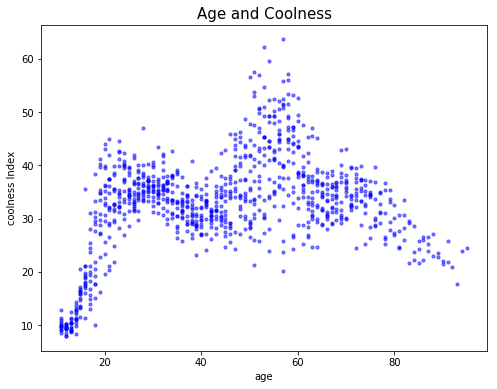

In [19]:
fig = plt.figure(figsize = (8,6))
plt.scatter(df.age,df.coolness,s=10,c='blue',alpha=0.5)
plt.xlabel("age")
plt.ylabel("coolness Index")
plt.title('Age and Coolness', fontsize = 15)
plt.show()

# (b) Use ordinary least squares (OLS) regression to t a stepwise function
Use 5 bins [11; 22), [22; 40), [40; 59), [59; 77), [77; 95].
1. Plot this step function on top of the scatterplot of the data from part (a).
2. Report your estimated step function values for each bin.
3. What is the predicted coolness of a 73-year old from the stepwise function?

In [20]:
df['G1'] = ['1' if (x>=11) & (x<22) else '0' for x in df['age']]
df['G2'] = ['1' if (x>=22) & (x<40) else '0' for x in df['age']]
df['G3'] = ['1' if (x>=40) & (x<59) else '0' for x in df['age']]
df['G4'] = ['1' if (x>=59) & (x<77) else '0' for x in df['age']]
df['G5'] = ['1' if (x>=77) & (x<=95) else '0' for x in df['age']]
df.head(), df.shape

(    age   coolness G1 G2 G3 G4 G5
 0  11.0  10.981602  1  0  0  0  0
 1  11.0  11.364925  1  0  0  0  0
 2  11.0  10.190227  1  0  0  0  0
 3  11.0   9.903725  1  0  0  0  0
 4  11.0   8.997918  1  0  0  0  0, (956, 7))

In [21]:
#X=df.iloc[:,2:7]
X=df[["G1","G2","G3","G4","G5"]]
X.head()

,G1,G2,G3,G4,G5
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [22]:
reg1 = sm.OLS(endog=df.coolness, exog=X.astype(float), missing='drop') # .astype(float) because I put '1' and '0' above
reg_results = reg1.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:               coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Tue, 26 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        21:16:13   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G1            20.1025      0.562     35.746      0.0

In [23]:
b1, b2, b3, b4, b5 = reg_results.params
print('b1 =', b1, '\nb2 =', b2,'\nb3 =', b3, '\nb4 =', b4,'\nb5 =', b5)

b1 = 20.102457252090748 
b2 = 34.47578807755938 
b3 = 37.63510549244961 
b4 = 35.22540004024275 
b5 = 27.296378244321282


In [24]:
print('Predicted Coolness of 73-year old is', reg_results.params[3])
print('Predicted Coolness of 73-year old is', reg_results.predict([0,0,0,1,0]))

Predicted Coolness of 73-year old is 35.22540004024275
Predicted Coolness of 73-year old is [35.22540004]


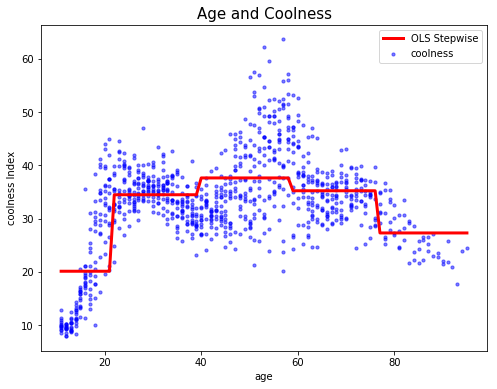

In [25]:
fig = plt.figure(figsize = (8,6))
plt.scatter(df.age,df.coolness,s=10,c='blue',alpha=0.5)
plt.plot(df.age,reg_results.predict(),c="red",label = "OLS Stepwise",linewidth='3')
plt.legend()
plt.xlabel("age")
plt.ylabel("coolness Index")
plt.title('Age and Coolness', fontsize = 15)
plt.show()

# (c) Fit a linear spline to the data over the 5 age bins from part (b).
Plot your continuous linear spline against a scatterplot of the data from part (a) and the estimated step function from part (b). Label your axes, include a legend, and give the plot a title. What is the predicted coolness of a 73-year old from the linear spline?

In [26]:
#Group data by age as LSQUnivariateSpline requires x to be strictly increasing
df2=df.groupby('age').mean()
df2['age']=df2.index
df2.head()

,coolness,age
age,,
11.0,10.110237,11.0
12.0,9.365623,12.0
13.0,10.015882,13.0
14.0,11.747109,14.0
15.0,15.434739,15.0


In [27]:
knots=[22,40,59,77]
spline1=LSQUnivariateSpline(df2.age.values, df2.coolness.values, t=knots, k=1)

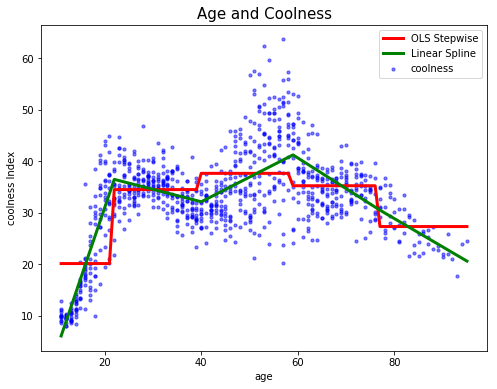

In [28]:
fig = plt.figure(figsize = (8,6))
plt.scatter(df.age,df.coolness,s=10,c='blue',alpha=0.5)
plt.plot(df.age,reg_results.predict(),c="red",label = "OLS Stepwise",linewidth = 3)
plt.plot(df.age,spline1(df.age),"green",label = "Linear Spline",linewidth = 3)
plt.legend()
plt.xlabel("age")
plt.ylabel("coolness Index")
plt.title('Age and Coolness', fontsize = 15)
plt.show()

In [29]:
print('Predicted Coolness of 73-year old is', spline1(73))

Predicted Coolness of 73-year old is 32.86784862349653


# (d) Fit a cubic spline (continuous) to the data over the 5 age bins

In [30]:
spline2=LSQUnivariateSpline(df2.age.values, df2.coolness.values, t=knots, k=3)

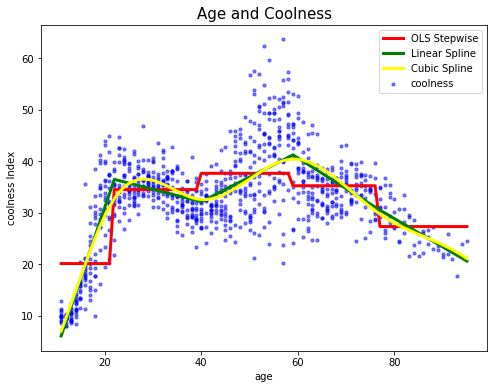

In [31]:
fig = plt.figure(figsize = (8,6))
plt.scatter(df.age,df.coolness,s=10,c='blue',alpha=0.5)
plt.plot(df.age,reg_results.predict(),c="red",label = "OLS Stepwise",linewidth = 3)
plt.plot(df.age,spline1(df.age),c="green",label = "Linear Spline",linewidth = 3)
plt.plot(df.age,spline2(df.age),c="yellow",label ="Cubic Spline",linewidth=3)
plt.legend()
plt.xlabel("age")
plt.ylabel("coolness Index")
plt.title('Age and Coolness', fontsize = 15)
plt.show()

In [32]:
print('Predicted Coolness of 73-year old is', spline2(73))

Predicted Coolness of 73-year old is 32.642301066279764
